In [1]:
import pandas as pd
import numpy as np
from econometron.Models.dynamicsge import linear_dsge
from econometron.utils.state_space import update_ss
from econometron.utils.estimation.MLE import simulated_annealing_kalman
from econometron.utils.estimation.Bayesian import rwm_kalman,compute_proposal_sigma,make_prior_function
from econometron.filters import kalman_smooth

In [2]:
# Model setup
equations=[ 
           "- r_t + phi*p_t=0",
           "p_t - beta * p_tp1 - kappa * (x_t - xbar_t) = 0",
           "x_t - x_tp1 + (1/g) * (r_t - p_tp1) = 0",
           "- xbar_tp1 + rho * xbar_t + sigmax = 0"]
variables=[ 'r','p','x','xbar']
states=['xbar']
exo_states=['xbar']
shock=['sigmax']
# Parameters dictionary
parameters = {
    'g': 5,      # Inverse of relative risk aversion (1/g)
    'beta': 0.99,       # Discount factor
    'kappa': 0,
    'rho': 0.95,        # Persistence of output gap target
    'phi': 1.5,         # Taylor rule inflation coefficient
    'd': 0.5,          # Calvo parameter
    'sigmax':0.01
}

In [3]:
sigma_X,beta,g,rho,phi,d=parameters['sigmax'],parameters['beta'],parameters['g'],parameters['rho'],parameters['phi'],parameters['d']
parameters['kappa']=((1-d)*(1-d*beta))/d

In [4]:
new_keynisian_model=linear_dsge(equations=equations,variables=variables,exo_states=exo_states,shocks=shock,parameters=parameters)

In [5]:
initial_guess = [1, 1, 1]
new_keynisian_model.set_initial_guess(initial_guess)

In [6]:
new_keynisian_model.compute_ss(initial_guess,method='fsolve',options={'xtol': 1e-10})

Steady-state residuals: [ 0.   -0.    0.   -0.01]


r        0.000000e+00
p        0.000000e+00
x      -4.940656e-324
xbar     0.000000e+00
dtype: float64

In [7]:
A,B,C=new_keynisian_model.approximate(method='analytical')

In [8]:
new_keynisian_model.solve_RE_model()
print("Policy Function (f):\n", new_keynisian_model.f)
print("State Transition (p):\n", new_keynisian_model.p)

Policy Function (f):
 [[-0.64715933]
 [-0.43143956]
 [ 0.94916702]]
State Transition (p):
 [[0.95]]


C:\Users\ASUS\econometron\econometron\Models\dynamicsge\__init__.py:986: UserWarning: Steady state contains zeros so normalize set to False.
  self._compute_irfs(T=T, t0=1, shocks=None, center=True)


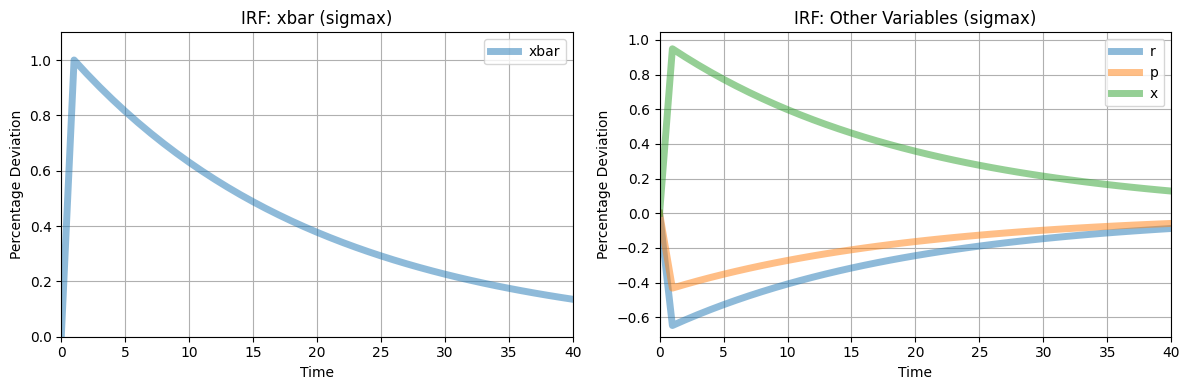

In [9]:
new_keynisian_model.plot_irfs()

In [10]:
new_keynisian_model.simulate(T=100, drop_first=10, covariance_matrix=np.array([[0.01**2]]))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15692\2665661609.py:1: UserWarning: Steady state contains zeros so normalize set to False.
  new_keynisian_model.simulate(T=100, drop_first=10, covariance_matrix=np.array([[0.01**2]]))


sigmax_t    xbar_t       r_t       p_t       x_t
0   0.002923  0.017110 -0.011073 -0.007382  0.016241
1   0.000338  0.016592 -0.010738 -0.007159  0.015749
2  -0.007869  0.007894 -0.005109 -0.003406  0.007493
3   0.002474  0.009973 -0.006454 -0.004303  0.009466
4   0.010979  0.020454 -0.013237 -0.008824  0.019414
..       ...       ...       ...       ...       ...
95 -0.008603 -0.010920  0.007067  0.004711 -0.010365
96  0.017918  0.007544 -0.004882 -0.003255  0.007160
97 -0.020795 -0.013629  0.008820  0.005880 -0.012936
98 -0.005358 -0.018306  0.011847  0.007898 -0.017375
99  0.003976 -0.013414  0.008681  0.005787 -0.012732

[100 rows x 5 columns]

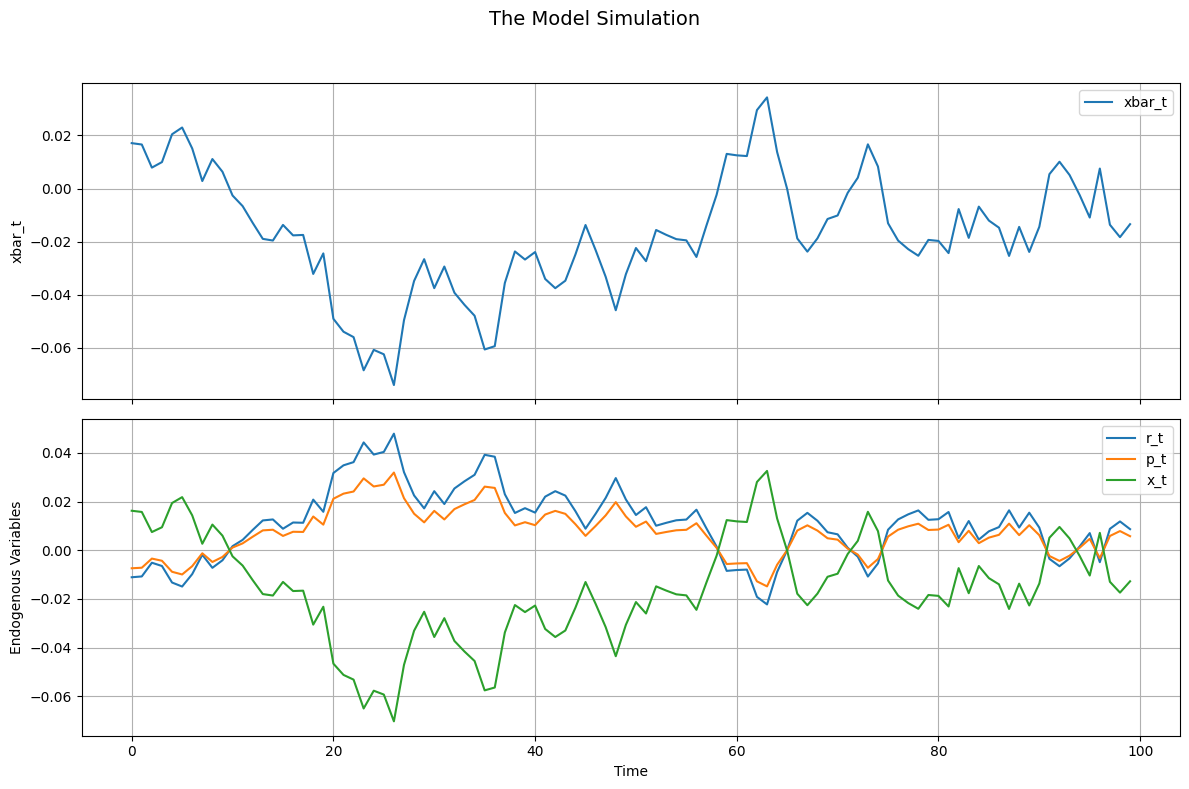

In [11]:
new_keynisian_model.simulations()

In [12]:
GDP=pd.read_csv("../../Data_Fred/gdp.csv", index_col=0, parse_dates=True)
Inflation=pd.read_csv("../../Data_Fred/inflation.csv", index_col=0, parse_dates=True)
Interest_Rate=pd.read_csv("../../Data_Fred/int_rate.csv", index_col=0, parse_dates=True)
mac_data = pd.concat([Interest_Rate, Inflation, GDP], axis=1)
mac_data = mac_data.dropna()
# Rename columns for clarity
mac_data.columns = ['Int', 'Inf', 'GDP']
# Apply log transformation01)
mac_data = np.log(mac_data)
# Remove rows with -inf, inf, or NaN values
mac_data = mac_data.replace([np.inf, -np.inf], np.nan).dropna().transpose()
#int for intrest_rate for simplcity

C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [13]:
if not np.all(mac_data.isna().sum()):
    print("All data is good")

All data is good


In [14]:
mac_data.shape

(3, 138)

In [15]:
from econometron.utils.data_preparation import TransformTS

In [16]:
TSP=TransformTS(mac_data.T,method='hp',lamb=1600)


=== Time Series Analysis ===

Stationarity Check (ADF Test):
Column Int: Non-stationary, p-value: 0.0985, ADF Statistic: -2.5738
Column Inf: Stationary, p-value: 0.0400, ADF Statistic: -2.9484
Column GDP: Non-stationary, p-value: 0.9493, ADF Statistic: -0.1013

Summary Statistics:
                Int           Inf           GDP
count  1.380000e+02  1.380000e+02  1.380000e+02
mean   2.359465e-14  3.829063e-15 -1.308675e-14
std    7.852392e-01  2.761745e-01  1.297678e-02
min   -2.446834e+00 -9.966646e-01 -4.334745e-02
25%   -3.281576e-01 -1.876235e-01 -6.431757e-03
50%    3.864531e-02  2.646428e-02 -6.952629e-04
75%    4.257549e-01  1.810891e-01  8.279967e-03
max    1.418004e+00  6.732762e-01  2.749663e-02

NaN Counts:
Int    0
Inf    0
GDP    0
dtype: int64

Correlation Matrix:
         Int       Inf       GDP
Int  1.00000 -0.163780  0.556330
Inf -0.16378  1.000000  0.225259
GDP  0.55633  0.225259  1.000000


In [17]:
TSP.get_transformed_data().describe()

Int           Inf           GDP
count  1.380000e+02  1.380000e+02  1.380000e+02
mean   2.359465e-14  3.829063e-15 -1.308675e-14
std    7.852392e-01  2.761745e-01  1.297678e-02
min   -2.446834e+00 -9.966646e-01 -4.334745e-02
25%   -3.281576e-01 -1.876235e-01 -6.431757e-03
50%    3.864531e-02  2.646428e-02 -6.952629e-04
75%    4.257549e-01  1.810891e-01  8.279967e-03
max    1.418004e+00  6.732762e-01  2.749663e-02

In [18]:
trans_data=TSP.get_transformed_data().T.values

<Axes: xlabel='observation_date'>

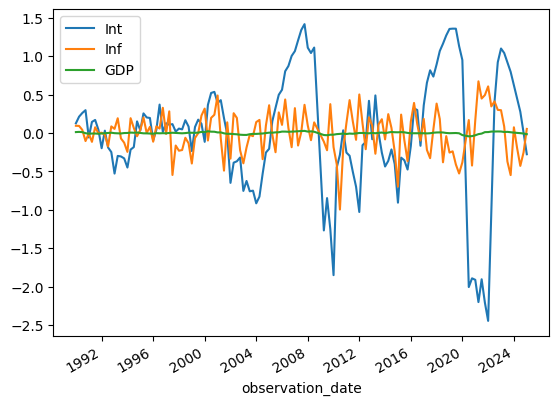

In [19]:
TSP.get_transformed_data().plot()

In [20]:
trans_data.shape

(3, 138)

In [21]:
def derived_fn(p):
    p['kappa'] = ((1 -p['d']) * (1-p['d']*p['beta']))/p['d']
#since we have kappa is written in function of Beta nd delta , the derived_fn here is param fixer , for parameter that are not intialized  
def R_builder(p):
  A1 = np.array([[1, -p['phi'], 0],
                    [0, 1, -p['kappa']],
                    [1/p['g'], 0, 1]])
  if abs(np.linalg.det(A1)) < 1e-6:
    raise ValueError("A1 matrix is singular")
  R1= np.array([[p['sigma_r'], 0, 0],
                [0, p['sigma_p'], 0],
                [0, 0, p['sigma_y']]])
  R=np.linalg.solve(A1,R1)
  return R
def C_builder(p):
    return np.array([[p['sigmax']]])

In [22]:
base_params = {
    'g': 1.00000000e+01,
    'beta': 8.97384125e-01,
    'kappa': 0.8,
    'rho': 9.61923424e-01,
    'phi': 1,
    'd': 8.64607398e-01 ,
    'sigmax': 7.52359617e-03,
    'sigma_y': 0.01,
    'sigma_p': 0.01,
    'sigma_r': 0.01
}
# [1.00000000e+01 8.97384125e-01 9.61923424e-01 1.00000000e+00
#  8.64607398e-01 7.52359617e-03 7.20758075e-03 1.00000000e-06
#  9.97050476e-03]
update_state_space = update_ss.make_state_space_updater(
    base_params=base_params,
    solver=new_keynisian_model.solve_RE_model,
    build_R=R_builder,
    build_C=C_builder,
    derived_fn=derived_fn
)

In [23]:
param_names = [k for k in base_params.keys() if k != 'kappa' and  k != 'beta'] # since Kappa is calulated 
initial_params = [base_params[name] for name in param_names]
fixed_params = {'beta':0.96} # calibrated models 
LB= [0,0,1,0,0,0,0,0]
UB= [10,1,5,1,1,1,1,1]

In [24]:
MLE_Results=simulated_annealing_kalman(trans_data,initial_params ,LB, UB, param_names, fixed_params, update_state_space,seed=1,T0=5,rt=0.9,nt=2,ns=2)

Starting Simulated Annealing with params: T0: 5, rt: 0.9, nt: 2, ns: 2, seed: 1
current evaluated vector of parameters: 
 [10.0, 0.961923424, 1, 0.864607398, 0.00752359617, 0.01, 0.01, 0.01]
initial loss function value: 569659.8115075711
current evaluated vector of parameters: 
 [8.34044009405148, 0.961923424, 1, 0.864607398, 0.00752359617, 0.01, 0.01, 0.01]


C:\Users\ASUS\econometron\econometron\Models\dynamicsge\__init__.py:842: RuntimeWarning: divide by zero encountered in divide
  eigenvals = np.abs(beta / alpha)
C:\Users\ASUS\econometron\econometron\Models\dynamicsge\__init__.py:842: RuntimeWarning: invalid value encountered in divide
  eigenvals = np.abs(beta / alpha)


current evaluated vector of parameters: 
 [10.0, 0.30233257263183977, 1, 0.864607398, 0.00752359617, 0.01, 0.01, 0.01]
current evaluated vector of parameters: 
 [10.0, 0.961923424, 1.7450408455106836, 0.864607398, 0.00752359617, 0.01, 0.01, 0.01]
current evaluated vector of parameters: 
 [10.0, 0.961923424, 1, 0.6581423464613398, 0.00752359617, 0.01, 0.01, 0.01]
current evaluated vector of parameters: 
 [10.0, 0.961923424, 1, 0.6581423464613398, 0.08515706417671388, 0.01, 0.01, 0.01]
current evaluated vector of parameters: 
 [10.0, 0.961923424, 1, 0.6581423464613398, 0.08515706417671388, 0.6852195003967595, 0.01, 0.01]
current evaluated vector of parameters: 
 [10.0, 0.961923424, 1, 0.6581423464613398, 0.08515706417671388, 0.6852195003967595, 0.8781174363909454, 0.01]
current evaluated vector of parameters: 
 [10.0, 0.961923424, 1, 0.6581423464613398, 0.08515706417671388, 0.6852195003967595, 0.8781174363909454, 0.35093502035680446]
current evaluated vector of parameters: 
 [8.346096047

In [25]:
MLE_Results['table']

Parameter  Estimate  Std Error   P-Value  Log-Likelihood  \
0         g  7.372995  10.954679  0.500918      -641.20519   
1       rho  0.887738   0.027486  0.000000      -641.20519   
2       phi  3.402830   0.300183  0.000000      -641.20519   
3         d  0.003083   0.000979  0.001639      -641.20519   
4    sigmax  0.006405   0.000385  0.000000      -641.20519   
5   sigma_y  0.107098   0.157799  0.497328      -641.20519   
6   sigma_p  0.004041   0.247467  0.986971      -641.20519   
7   sigma_r  0.999999   0.059121  0.000000      -641.20519   

                Method  
0  Simulated Annealing  
1  Simulated Annealing  
2  Simulated Annealing  
3  Simulated Annealing  
4  Simulated Annealing  
5  Simulated Annealing  
6  Simulated Annealing  
7  Simulated Annealing

In [26]:
from scipy.stats import gamma, beta

In [27]:
param_names = ['g', 'rho','phi', 'd', 'sigmax', 'sigma_y', 'sigma_p', 'sigma_r']
priors = {
    'g':       (gamma, {'a': 5, 'scale': 1}),
    'rho':     (beta, {'a': 19, 'b': 1}),
    'phi':     (gamma, {'a': 3, 'scale': 0.5}),
    'd':       (beta, {'a': 10, 'b': 10}),
    'sigmax':  (gamma, {'a': 2, 'scale': 0.02}),
    'sigma_y': (gamma, {'a': 2, 'scale': 0.02}),
    'sigma_p': (gamma, {'a': 2, 'scale': 0.02}),
    'sigma_r': (gamma, {'a': 2, 'scale': 0.02}),
}

bounds = {
    'g':        (0, 10),
    'rho':      (0, 1),
    'phi':      (1, 5),
    'd':        (0, 1),
    'sigmax':   (0, np.inf),
    'sigma_y':  (0, np.inf),
    'sigma_p':  (0, np.inf),
    'sigma_r':  (0, np.inf),
}

# Create the generalized prior function
prior = make_prior_function(param_names, priors, bounds, verbose=True)


In [28]:
params = [5.0,0.95, 1.5, 0.5, 0.04, 0.04, 0.04, 0.04]
logp = prior(params)

[Log Prior] g: logpdf(5.0000) = -1.740
[Log Prior] rho: logpdf(0.9500) = 2.021
[Log Prior] phi: logpdf(1.5000) = -0.803
[Log Prior] d: logpdf(0.5000) = 1.260
[Log Prior] sigmax: logpdf(0.0400) = 2.605
[Log Prior] sigma_y: logpdf(0.0400) = 2.605
[Log Prior] sigma_p: logpdf(0.0400) = 2.605
[Log Prior] sigma_r: logpdf(0.0400) = 2.605
[Total Log Prior] = 11.158 | Params = [5.0, 0.95, 1.5, 0.5, 0.04, 0.04, 0.04, 0.04]


In [29]:
base_std = [0.02,0.02, 0.01, 0.01, 0.002, 0.002, 0.002, 0.002]
sigma = compute_proposal_sigma(len(initial_params), LB,UB, base_std=base_std)

In [30]:
int_param= [9.643278182282456, 0.34858783348434547, 1.0692420518924992, 0.35879218703443405, 0.1677877601951951, 0.08009571415665534, 0.06274389287649895, 0.8110634657092273]

In [31]:
Bayes_res=rwm_kalman(trans_data,initial_params,LB,UB,param_names,fixed_params,update_state_space,n_iter=10000,burn_in=100,thin=10,sigma=sigma,seed=1,prior=prior)

current evaluated vector of parameters: 
 [1.00000000e+01 9.61923424e-01 1.00000000e+00 8.64607398e-01
 7.52359617e-03 1.00000000e-02 1.00000000e-02 1.00000000e-02]
[Bound Error] g = 10.0000 not in (0, 10)
current evaluated vector of parameters: 
 [4.17022005 0.72032449 1.0004575  0.30233257 0.14675589 0.09233859
 0.18626021 0.34556073]
[Log Prior] g: logpdf(4.1702) = -1.636
[Log Prior] rho: logpdf(0.7203) = -2.961
[Log Prior] phi: logpdf(1.0005) = -0.614
[Log Prior] d: logpdf(0.3023) = -0.270
[Log Prior] sigmax: logpdf(0.1468) = -1.433
[Log Prior] sigma_y: logpdf(0.0923) = 0.825
[Log Prior] sigma_p: logpdf(0.1863) = -3.170
[Log Prior] sigma_r: logpdf(0.3456) = -10.517
[Total Log Prior] = -19.775 | Params = [4.17022005 0.72032449 1.0004575  0.30233257 0.14675589 0.09233859
 0.18626021 0.34556073]
Found valid starting point after 1 attempts: [4.17022005 0.72032449 1.0004575  0.30233257 0.14675589 0.09233859
 0.18626021 0.34556073]
current evaluated vector of parameters: 
 [4.1875282  0.

C:\Users\ASUS\econometron\econometron\Models\dynamicsge\__init__.py:842: RuntimeWarning: divide by zero encountered in divide
  eigenvals = np.abs(beta / alpha)
C:\Users\ASUS\econometron\econometron\Models\dynamicsge\__init__.py:842: RuntimeWarning: invalid value encountered in divide
  eigenvals = np.abs(beta / alpha)


[Log Prior] g: logpdf(4.1988) = -1.638
[Log Prior] rho: logpdf(0.7146) = -3.104
[Log Prior] phi: logpdf(1.0104) = -0.614
[Log Prior] d: logpdf(0.3019) = -0.276
[Log Prior] sigmax: logpdf(0.1469) = -1.440
[Log Prior] sigma_y: logpdf(0.0923) = 0.827
[Log Prior] sigma_p: logpdf(0.1869) = -3.200
[Log Prior] sigma_r: logpdf(0.3452) = -10.500
[Total Log Prior] = -19.945 | Params = [4.1988151  0.7145884  1.01035665 0.30194436 0.14692646 0.09227033
 0.1869354  0.34521486]
current evaluated vector of parameters: 
 [4.21684691 0.71559338 1.01396007 0.30126063 0.14690188 0.09208317
 0.18688182 0.34532093]
[Log Prior] g: logpdf(4.2168) = -1.639
[Log Prior] rho: logpdf(0.7156) = -3.079
[Log Prior] phi: logpdf(1.0140) = -0.614
[Log Prior] d: logpdf(0.3013) = -0.288
[Log Prior] sigmax: logpdf(0.1469) = -1.439
[Log Prior] sigma_y: logpdf(0.0921) = 0.835
[Log Prior] sigma_p: logpdf(0.1869) = -3.197
[Log Prior] sigma_r: logpdf(0.3453) = -10.505
[Total Log Prior] = -19.926 | Params = [4.21684691 0.715593

In [32]:
Bayes_res['table']

Parameter  Estimate  95% Credible Interval Lower  \
0         g  9.543176                     6.004804   
1       rho  0.477082                     0.323937   
2       phi  1.011647                     1.000390   
3         d  0.409261                     0.312266   
4    sigmax  0.149160                     0.142202   
5   sigma_y  0.087492                     0.078456   
6   sigma_p  0.182415                     0.172233   
7   sigma_r  0.436860                     0.350562   

   95% Credible Interval Upper  Log-Prior  Log-Likelihood   Posterior Plot  \
0                     9.996791 -32.099067      254.007397  Figure(800x600)   
1                     0.610455 -32.099067      254.007397  Figure(800x600)   
2                     1.086377 -32.099067      254.007397  Figure(800x600)   
3                     0.470787 -32.099067      254.007397  Figure(800x600)   
4                     0.157921 -32.099067      254.007397  Figure(800x600)   
5                     0.098598 -32.099067      254.007397  Figure(800x600)   
6                     0.195205 -32.099067      254.007397  Figure(800x600)   
7                     0.511442 -32.099067      254.007397  Figure(800x600)   

  Method  
0    RWM  
1    RWM  
2    RWM  
3    RWM  
4    RWM  
5    RWM  
6    RWM  
7    RWM

In [33]:
new_set_of_params=MLE_Results['result']

In [42]:
new_set_of_params

{'x': [7.372995153121833,
  0.8877384102847888,
  3.402829610145752,
  0.003082995908878812,
  0.006405250449062197,
  0.10709796645551589,
  0.004041130660498564,
  0.999999142653202],
 'fun': 641.2051900989034,
 'N_FUNC_EVALS': 2657,
 'message': 'Simulated Annealing terminated successfully.'}

In [44]:
base_param= {
    'g': 1.00000000e+01,
    'beta': 8.97384125e-01,
    'kappa': 0.8,
    'rho': 9.61923424e-01,
    'phi': 1,
    'd': 8.64607398e-01 ,
    'sigmax': 7.52359617e-03,
    'sigma_y': 0.01,
    'sigma_p': 0.01,
    'sigma_r': 0.01
}

In [ ]:
def update_parameters(resr, fixed_params, old_params):
    """
    Update the parameters dictionary with new values.
    
    Parameters:
    - resr: A DataFrame, dict, or similar containing new parameter values. If DataFrame, expects 'Parameter' and 'Estimate' columns.
    - fixed_params: The fixed parameters that should not be changed.
    - old_params: The base parameters to be updated.
    
    Returns:
    - new_params: New parameters dictionary with updated values.
    """
    import pandas as pd
    # Copy old_params to avoid mutating the original
    new_params = old_params.copy()
    # Update with fixed_params
    for key, value in fixed_params.items():
        new_params[key] = value
    # Handle DataFrame with 'Parameter' and 'Estimate' columns
    if isinstance(resr, pd.DataFrame):
        if 'Parameter' in resr.columns and 'Estimate' in resr.columns:
            res_dict = dict(zip(resr['Parameter'], resr['Estimate']))
        else:
            # fallback: use first row if columns are not named
            res_dict = dict(resr.iloc[0, :])
    elif isinstance(resr, dict):
        res_dict = resr
    else:
        raise ValueError("resr must be a DataFrame or dict")
    for key, value in res_dict.items():
        if key in new_params and key not in fixed_params:
            new_params[key] = value
    return new_params


In [94]:
new=update_parameters(MLE_Results['table'], {'beta': 0.96}, base_param)

{'Parameter': 0          g
1        rho
2        phi
3          d
4     sigmax
5    sigma_y
6    sigma_p
7    sigma_r
Name: Parameter, dtype: object, 'Estimate': 0    7.372995
1    0.887738
2    3.402830
3    0.003083
4    0.006405
5    0.107098
6    0.004041
7    0.999999
Name: Estimate, dtype: float64}
aaa {'g': 10.0, 'beta': 0.96, 'kappa': 0.8, 'rho': 0.961923424, 'phi': 1, 'd': 0.864607398, 'sigmax': 0.00752359617, 'sigma_y': 0.01, 'sigma_p': 0.01, 'sigma_r': 0.01}


In [90]:
new

{'g': 10.0,
 'beta': 0.96,
 'kappa': 0.8,
 'rho': 0.961923424,
 'phi': 1,
 'd': 0.864607398,
 'sigmax': 0.00752359617,
 'sigma_y': 0.01,
 'sigma_p': 0.01,
 'sigma_r': 0.01}

In [50]:
Smoothed_state=kalman_smooth(trans_data,params,update_state_space,plot=True)

Running Kalman smoother...


TypeError: cannot convert dictionary update sequence element #0 to a sequence

In [ ]:
new_keynisian_model.set_new_pramaters(new_set_of_params)

In [ ]:
new_keynisian_model.simulate(T=100, drop_first=10, covariance_matrix=np.array([[0.01**2]]))

In [ ]:
new_keynisian_model.simulations()